In [37]:
import sys
sys.path.append('./.local/lib/python3.5/site-packages')
print(sys.path)

['/usr/lib/python35.zip', '/usr/lib/python3.5', '/usr/lib/python3.5/plat-x86_64-linux-gnu', '/usr/lib/python3.5/lib-dynload', '', '/usr/local/lib/python3.5/dist-packages', '/usr/local/lib/python3.5/site-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.5/dist-packages/IPython/extensions', '/home/jupyter/.ipython', './.local/lib/python3.5/', './.local/lib/python3.5/', './.local/lib/python3.5/site-packages', './.local/lib/python3.5/site-packages']


In [2]:
#!pip3 uninstall torch
!pip3 install torch==0.4.1

In [43]:
import torch

In [ ]:
!pip3 install fastai

In [ ]:
from fastai.conv_learner import *

In [46]:
!pip3 install google-images-download

from google_images_download import google_images_download

In [96]:
def download_data(num):
    response = google_images_download.googleimagesdownload()  
    arguments = {"keywords": "Indian_Cuisine,Mexican_Cuisine,Italian_Cuisine","limit":num,"print_urls":True, "format":"jpg"}   #creating list of arguments
    paths = response.download(arguments)

In [ ]:
download_data(100)
!mkdir data
!mkdir data/train
!mv downloads/* data/train/

In [100]:
!mkdir data/valid

In [107]:
import shutil
def moveToValid(cuisine):
    dirname = 'data/train/'+cuisine
    if not os.path.exists('data/valid/'+cuisine):
        os.mkdir('data/valid/'+cuisine)
    num = 1
    for img in os.listdir(dirname):
        if num <= 20:
            shutil.move(dirname+'/'+img, 'data/valid/'+cuisine+'/')
        else:
            return
        num += 1

In [108]:
moveToValid('Indian_Cuisine')
moveToValid('Italian_Cuisine')
moveToValid('Mexican_Cuisine')

In [111]:
from PIL import Image
def removeNonReadable(dirname):
   
    for img in os.listdir(dirname):
        try:
            Image.open(dirname+img)
        except:
            os.remove(dirname+img)
removeNonReadable('data/valid/Indian_Cuisine/')
removeNonReadable('data/valid/Italian_Cuisine/')
removeNonReadable('data/valid/Mexican_Cuisine/')
removeNonReadable('data/train/Indian_Cuisine/')
removeNonReadable('data/train/Italian_Cuisine/')
removeNonReadable('data/train/Mexican_Cuisine/')

In [4]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

In [ ]:
def get_sampler(opt, paths, class_counts):
    sampler = None
    if opt.balance_class:
        weights = sum(class_counts)/(np.array(class_counts,dtype='float'))
        sampling_weights = []
        for sample in paths:
            sampling_weights.append(weights[sample[1]])
        sampler = data.sampler.WeightedRandomSampler(sampling_weights , len(sampling_weights))
    return sampler

In [112]:
data_dir = 'data/'

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(30),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
    ])
}
# TODO: Load the datasets with ImageFolder
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'valid']}
# TODO: Using the image datasets and the trainforms, define the dataloaders
batch_size = 64
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'valid']}
class_names = image_datasets['train'].classes
print(class_names)
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}
class_names = image_datasets['valid'].classes
print(class_names)

['Indian_Cuisine', 'Italian_Cuisine', 'Mexican_Cuisine']
['Indian_Cuisine', 'Italian_Cuisine', 'Mexican_Cuisine']


In [113]:
def display_image(dataloader, idx):
    img_info = dataloader.dataset.imgs[idx]
    img = plt.imread(img_info[0])
    plt.title(dataloader.dataset.classes[img_info[1]])
    plt.imshow(img)

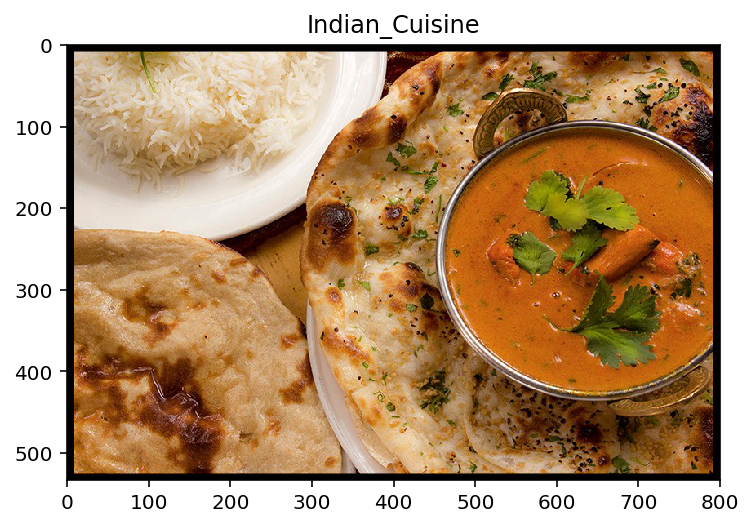

In [116]:
display_image(dataloaders['train'], 0)

In [118]:
model = models.resnet50(pretrained= True)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /home/jupyter/.torch/models/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:01<00:00, 52401679.57it/s]


In [119]:
for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Sequential(nn.Linear(2048, 512), 
                        nn.ReLU(),
                        nn.Dropout(0.2),
                        nn.Linear(512, 3),
                        nn.LogSoftmax(dim = 1))
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.fc.parameters(), lr = 0.003)
model.to("cpu")

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

In [ ]:
epochs = 1
steps = 0
running_loss = 0
print_every = 5
train_losses, test_losses = [], []
for epoch in range(10):
    try:
        for inputs, labels in dataloaders['train']:
            steps += 1
            inputs, labels = inputs.to("cpu"), labels.to("cpu")
            optimizer.zero_grad()
            logps = model.forward(inputs)
            loss = criterion(logps, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
            if steps % print_every == 0:
                test_loss = 0
                accuracy = 0
                model.eval()
                with torch.no_grad():
                    for inputs, labels in dataloaders['valid']:
                        inputs, labels = inputs.to("cpu"), labels.to("cpu")
                        logps = model.forward(inputs)
                        batch_loss = criterion(logps, labels)
                        test_loss += batch_loss.item()
                        ps = torch.exp(logps)
                        top_p, top_class = ps.topk(1, dim=1)
                        equals = top_class == labels.view(*top_class.shape)
                        accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                train_losses.append(running_loss/len(trainloader))
                test_losses.append(test_loss/len(testloader))                    
                print("Epoch: "+ str((epoch+1)/epochs))
                print("Train loss: "+ str(running_loss/print_every))
                print("Test loss: "+ str(test_loss/len(testloader)))
                print("Test accuracy: "+ str(accuracy/len(testloader)))
                running_loss = 0
                model.train()
    finally:
        print('done')
            
torch.save(model, 'cuisinemodel.pth')

In [ ]:
!ls